In [ ]:
data_path = 'content'
output_path = 'content'

Install Required packages and import libraries

In [ ]:
pip install transformers

In [ ]:
pip install -U torchtext==0.6.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup

import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

Data Loading

In [5]:
# Load CSV file with dataset. Perform basic transformations.
df = pd.read_csv("sem18(train+test)and sem22(train with data aug)+(13k).csv")

In [6]:
df

,Unnamed: 0,tweet,sarcastic
0,0,the biggest only problem thing i got from coll...,1
1,1,the absolutely only thing i got fired from the...,1
2,2,perhaps the second only nice thing i got out f...,1
3,3,i love it when college professors randomly dra...,1
4,4,i really love it funny when professors constan...,1
...,...,...,...
19981,13551,['8-9ft man found in ancient indian burial mou...,0
19982,13552,"[""Second Scottish independence referendum 'on ...",0
19983,13553,"['Pinoy Cyborg by James Simmons', 'Mag-ingat s...",0
19984,13554,"['The logic here is flawless!', ""No it isn't, ...",0


Data Cleaning

In [7]:
import re
from nltk.corpus import stopwords  ## stopwords from nltk corpus
import nltk

b = list(df["tweet"])


nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
  
    review = ' '.join(review)

    corpus.append(review)
df = df.assign(clean_tweet1 = corpus)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
df = df.drop_duplicates(subset=["clean_tweet1"])

Data Visualisation

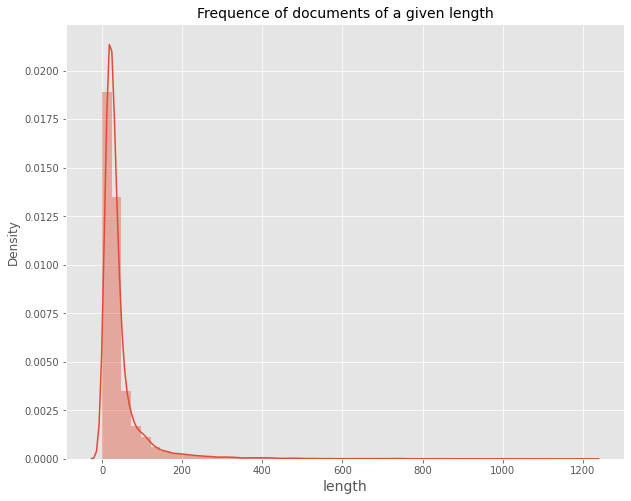

In [9]:
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = df['clean_tweet1'].apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [10]:
# Save preprocessed data, cropped to max length of the model.
df['clean_tweet1'] = df['clean_tweet1'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv("prep_news.csv")

In [24]:
import tensorflow as tf

In [26]:
# Set random seed and set device to GPU.
torch.manual_seed(17)

if torch.cuda.is_available():
    device = torch.device('GPU:0')
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device('cpu')
device = tf.test.gpu_device_name()
print(device)

''

In [12]:
# Initialize tokenizer.
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [13]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)


# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = {'clean_tweet1' : ('clean_tweet1', text_field), 'sarcastic' : ('sarcastic', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path="prep_news.csv", 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='sarcastic')

# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.clean_tweet1), 
                                               sort=True, 
                                               sort_within_batch=False)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [14]:
test_data

In [15]:
type(test_iter)

torchtext.data.iterator.Iterator

In [16]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [17]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base',return_dict=False)
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 2)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x  

In [18]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler = None,
             valid_period = len(train_iter),
             num_epochs = 5,return_dict=False):
    
    # Pretrain linear layers, do not train bert
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set bert parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [19]:
# Training Function

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler = None,
          num_epochs = 5,
          valid_period = len(train_iter),
          output_path = output_path,return_dict=False):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Train loop
    for epoch in range(num_epochs):
        for (source, target), _ in train_iter:
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source,  
                           attention_mask=mask)
            #output = model(input_ids=source,
            #              labels=target,
            #              attention_mask=mask)
            
            loss = torch.nn.CrossEntropyLoss()(y_pred, target)
            #loss = output[0]
            
            loss.backward()
            
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            
            # Optimizer and scheduler step
            optimizer.step()    
            scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for (source, target), _ in valid_iter:
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, 
                                       attention_mask=mask)
                        #output = model(input_ids=source,
                        #               labels=target,
                        #               attention_mask=mask)
                        
                        loss = torch.nn.CrossEntropyLoss()(y_pred, target)
                        #loss = output[0]
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # print summary
                print('Epoch [{}/{}], global step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                # checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint('model.pkl', model, best_valid_loss)
                    save_metrics('metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
    
    save_metrics('metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
    print('Training done!')

In [ ]:
# Main training loop
NUM_EPOCHS = 5
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.4)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-4)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS =10
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


======================= Start pretraining ==============================
Epoch [1/5], global step [875/4375], PT Loss: 0.7189, Val Loss: 0.6929
Epoch [2/5], global step [1750/4375], PT Loss: 0.7023, Val Loss: 0.6935
Epoch [3/5], global step [2625/4375], PT Loss: 0.6982, Val Loss: 0.6930
Epoch [4/5], global step [3500/4375], PT Loss: 0.6959, Val Loss: 0.6911
Epoch [5/5], global step [4375/4375], PT Loss: 0.6935, Val Loss: 0.6902
Pre-training done!
======================= Start training =================================
Epoch [1/10], global step [875/8750], Train Loss: 0.6894, Valid Loss: 0.6825


Loss Curve

In [ ]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics('metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

In [ ]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, digits=4))
    print(y_pred)
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])
    return y_pred

In [ ]:
test_iter

In [ ]:
model = ROBERTAClassifier()
model = model.to(device)

load_checkpoint('model.pkl', model)

y_pred =evaluate(model, test_iter)

In [ ]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

Prediction on test data 

In [ ]:
df1  =  pd.read_csv("taskA.En.input.csv")   # test data for Sub-Task A

In [ ]:
df1

In [ ]:
df1 = df1.assign(ramdom_label=[1 for i in range(len(df1["text"]))])

In [ ]:
df1

In [ ]:
df1.to_csv("abc.csv")

In [ ]:
df1

In [ ]:
fields = {'text' : ('text', text_field), 'ramdom_label' : ('ramdom_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data = TabularDataset(path="abc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


In [ ]:
test_data

In [ ]:
test_iter

In [ ]:
model = ROBERTAClassifier()     ### Roberta classifier
model = model.to(device)

load_checkpoint('model.pkl', model)     ### checkpoint

y_pred = evaluate(model, test_iter)

In [ ]:
df1 = df1.assign(task_a_en=y_pred)

In [ ]:
df1

In [ ]:
df1["task_a_en"].value_counts()

In [ ]:
test_data = pd.read_csv("task_A_En_test.csv")

In [ ]:
test_data = test_data.assign(pred=y_pred)

In [ ]:
print(classification_report(test_data["sarcastic"], test_data["pred"]))

In [ ]:
import pandas as pd

In [ ]:
task_c=pd.read_csv("task_C_En_test.csv")

In [ ]:
task_c

In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(task_c["text_0"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
task_c = task_c.assign(clean_text0 = corpus)


import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
ps = PorterStemmer()


b = list(task_c["text_1"])


wordnet=WordNetLemmatizer()
nltk.download('wordnet')
import nltk.corpus
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
import string
exclude = set(string.punctuation)
corpus = []
for i in range(len(b)):
    review =re.sub(r'http\S+', ' ', str(b[i]))
    review = re.sub("\d*\.\d+","",review)
    review =re.sub(r'@\S+', ' ', review)
    
    TAG_RE = re.compile(r'<[^>]+>')
    review = TAG_RE.sub('', review)
    
    review = re.sub('\[[^]]*\]', ' ', review)
    
    review = review.lower()
    review = review.split()
    
    review = ' '.join(review)

    

    corpus.append(review)
task_c = task_c.assign(clean_text1 = corpus)

In [ ]:
task_c

In [ ]:
task_c = task_c.assign(random_label=[1 for i in range(len(task_c["clean_text0"]))])


In [ ]:
task_c.to_csv("taskc.csv")

In [ ]:
task_c


In [ ]:
fields = {'clean_text0' : ('clean_text0', text_field), 'random_label' : ('random_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data = TabularDataset(path="taskc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
import numpy as np

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, attention_mask=mask)
                logits = output.detach().cpu().numpy()
                y_pred.append(logits)
                
                flat_predictions1 = [np.max(item) for sublist in y_pred for item in sublist]
                y_true.extend(target.tolist())
    
    return flat_predictions1

In [ ]:
flat_predictions0 = evaluate(model, test_iter)

In [ ]:
flat_predictions0


In [ ]:
fields = {'clean_text1' : ('clean_text1', text_field), 'random_label' : ('random_label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
test_data1 = TabularDataset(path="taskc.csv", format='CSV', fields=fields)

# Test iterator, no shuffling or sorting required.
test_iter1 = Iterator(test_data1, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [ ]:
flat_predictions1 = evaluate(model, test_iter1)

In [ ]:
len(flat_predictions0)

In [ ]:
task_c_en = []

In [ ]:
flat_predictions1[0]

In [ ]:

for i in range(200):
  if flat_predictions0[i]>flat_predictions1[i]:
    task_c_en.append(0)
  if flat_predictions0[i]<flat_predictions1[i]:
    task_c_en.append(1)
task_c_en

In [ ]:
print(classification_report(list(task_c["sarcastic_id"]), task_c_en))